# **Time Series Analysis**
This notebook demonstrates essential techniques for working with time series data. Time series forecasting is crucial in predicting future values based on historical data, and the notebook covers both simple and advanced techniques for accurate predictions.

### Topics Covered in this notebook:
1. Loading and Visualizing Time Series Data
2. Feature Engineering for Time Series
3. Modeling with Simple Linear Regression
4. Implementing Advanced Models with XGBoost
5. Model Evaluation and Performance Metrics

## **Importing Libraries**
Let us first import all the relevant Python libraries required:
1. **os :** for interacting with the operating system
2. **kagglehub :** for accessing datasets and other resources from Kaggle
3. **pandas :** for data manipulation and analysis
4. **numpy :** for numerical computations
5. **matplotlib :** for data visualization
6. **seaborn :** for enhanced data visualization
7. **statsmodels:** for time series analysis
8. **sklearn:** for machine learning models (Linear Regression, Model Evaluation)
9. **xgboost:** for advanced modeling with the XGBoost algorithm



In [5]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
#!pip install xgboost

Now that we have imported the required libraries, let us load a dataset from Kaggle. We will be using the Hourly Energy Consumption Dataset in today's notebook.

## **Loading A Dataset & Visualization**

In [9]:
# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Bobby\.cache\kagglehub\datasets\robikscube\hourly-energy-consumption\versions\3


In [10]:
dataset_path = "C:/Users/Bobby/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3"

files = os.listdir(dataset_path)
print(files)

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv']


In [11]:
file_path = "C:/Users/Bobby/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJME_hourly.csv"

In [12]:
df = pd.read_csv(file_path)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [13]:
df

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


Now that the dataset has been loaded, let us now visualize it.

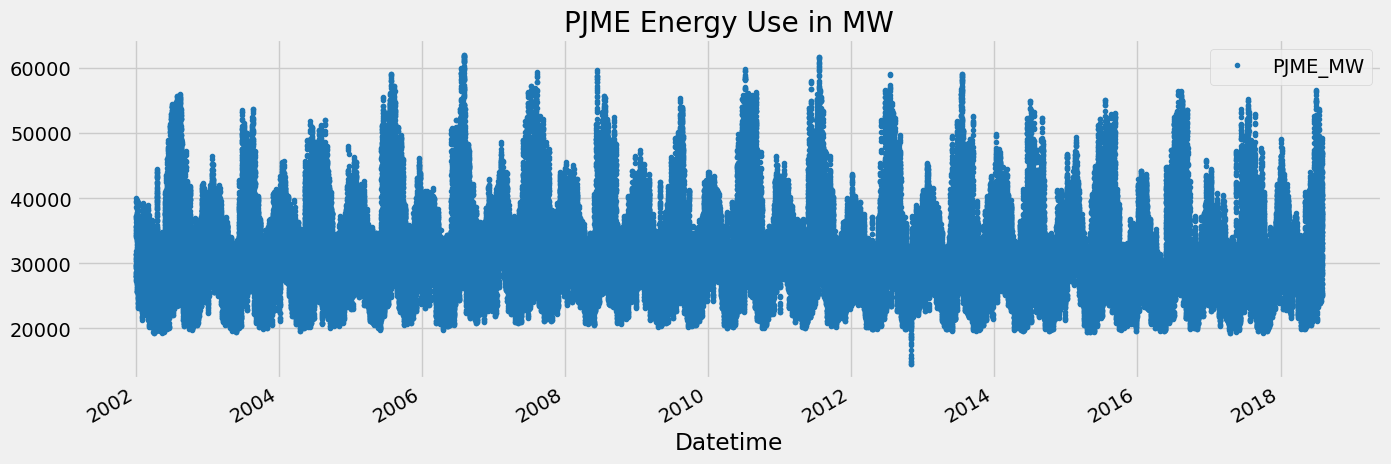

In [15]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

<Figure size 640x480 with 0 Axes>

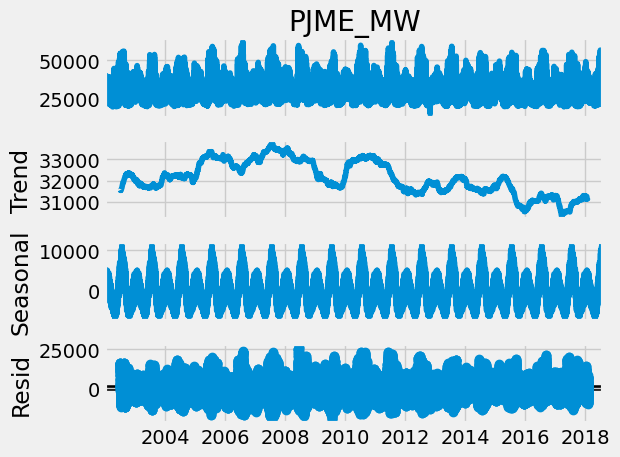

In [16]:
plt.clf()
# Perform seasonal decomposition
result = seasonal_decompose(df['PJME_MW'], model='additive', period=(24*365))  # Assuming yearly seasonality

# Plot decomposition
result.plot()
plt.show()

In [17]:
# Get the last 6 months of data
shorter_df = df.tail(15*24) # Assuming hourly data, so 180 days * 24 hours

# If your data has a different frequency (e.g., daily), adjust the number of rows accordingly

shorter_df.head()

,PJME_MW
Datetime,
2018-07-19 01:00:00,29092.0
2018-07-19 02:00:00,27128.0
2018-07-19 03:00:00,25875.0
2018-07-19 04:00:00,25119.0
2018-07-19 05:00:00,25063.0


<Figure size 640x480 with 0 Axes>

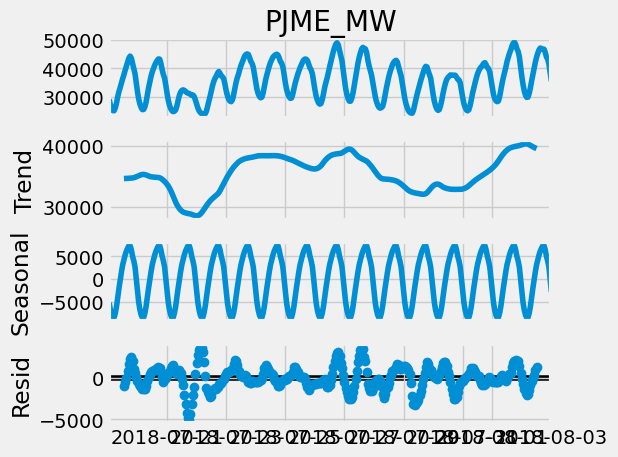

In [18]:
plt.clf()
# Perform seasonal decomposition
result = seasonal_decompose(shorter_df['PJME_MW'], model='additive', period=24)  # Assuming hourly data

# Plot decomposition
result.plot()
plt.show()

## **Train/Test Split**

<Figure size 640x480 with 0 Axes>

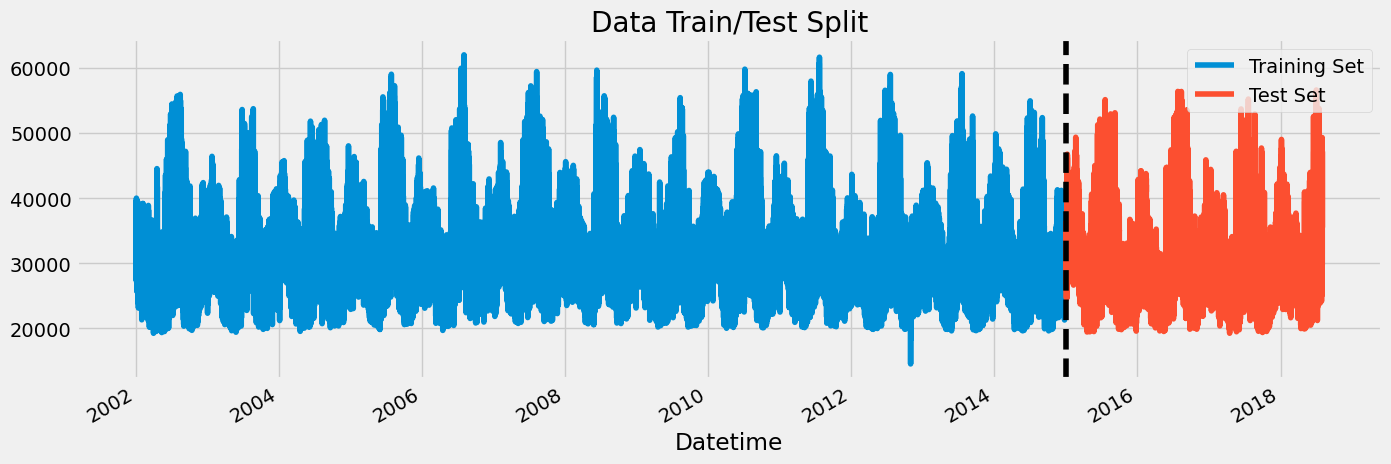

In [20]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Figure size 640x480 with 0 Axes>

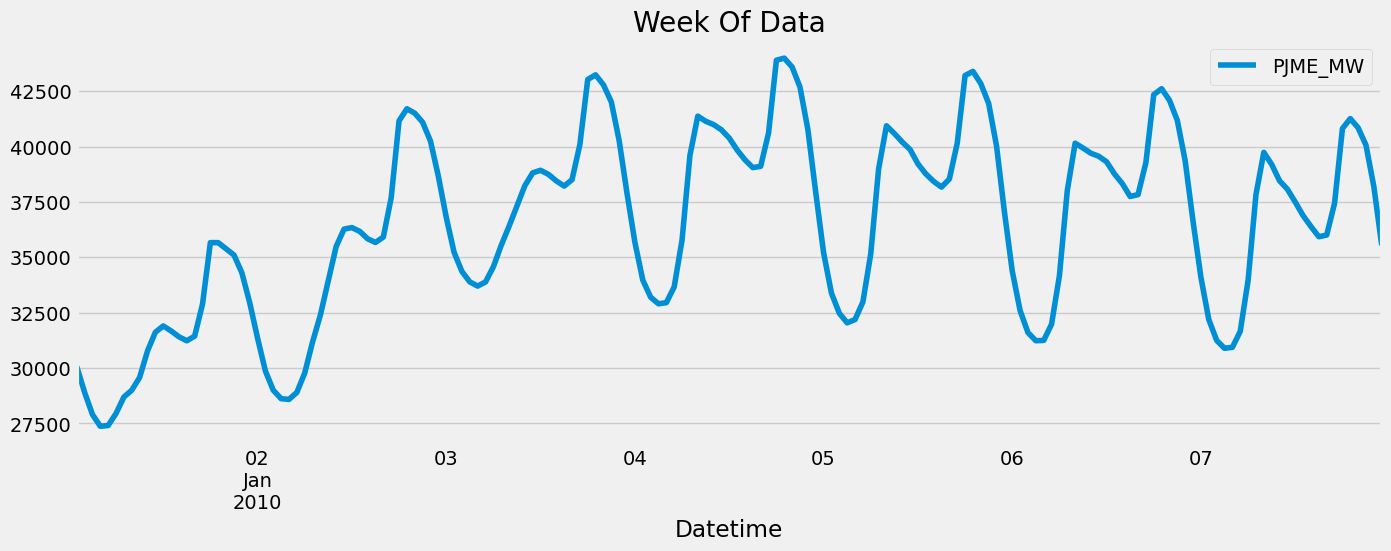

In [21]:
plt.clf()
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## **Feature Engineering**

In [23]:
def create_features(df):
    """
    Create time series features and lag features based on time series index.
    """
    df = df.copy()

    # Basic time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag_1d'] = df['PJME_MW'].shift(1)   # 1 day lag
    df['lag_1w'] = df['PJME_MW'].shift(7)   # 1 week lag
    df['lag_1m'] = df['PJME_MW'].shift(30)  # 1 month lag (approx. 30 days)
    df['lag_1y'] = df['PJME_MW'].shift(365) # 1 year lag

    # Rolling statistics features
    df['rolling_mean_3d'] = df['PJME_MW'].rolling(window=3).mean()  # Last 3 days rolling mean
    df['rolling_mean_30d'] = df['PJME_MW'].rolling(window=30).mean()  # Last month rolling mean
    df['rolling_mean_same_month_last_year'] = df['PJME_MW'].shift(365).rolling(window=30).mean()  # Same month previous year rolling mean
    df['rolling_mean_same_week_last_year'] = df['PJME_MW'].shift(365).rolling(window=7).mean()  # Same week previous year rolling mean

    return df

df = create_features(df)

## **Visualization Feature/Target Relationship**

<Figure size 640x480 with 0 Axes>

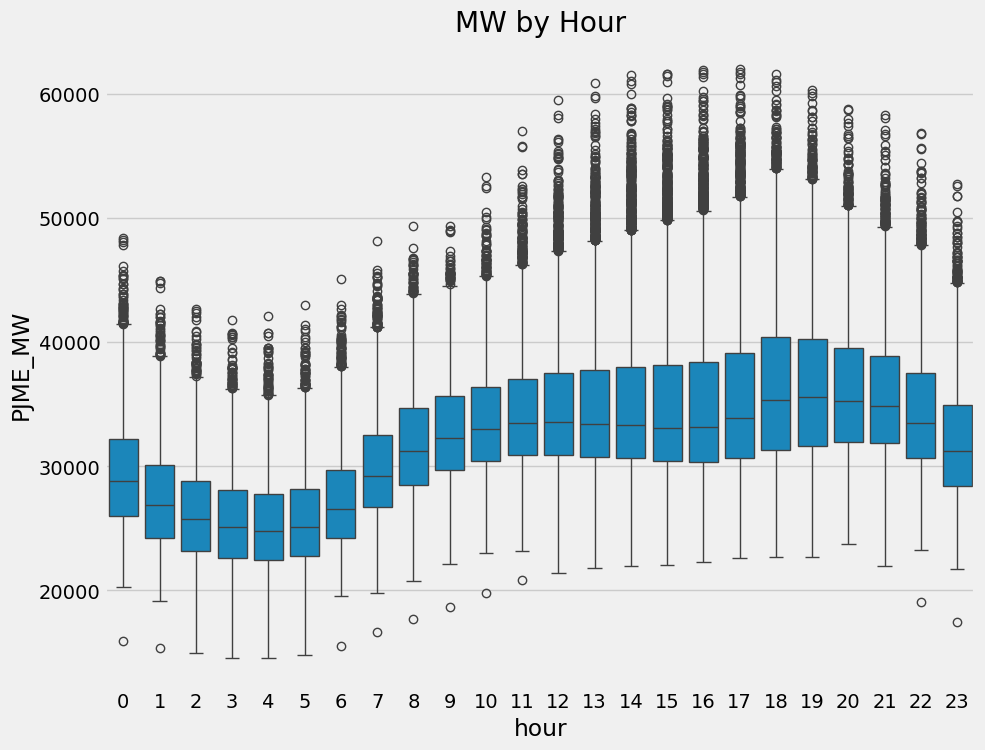

In [25]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\Bobby\AppData\Local\Temp\ipykernel_2820\4164888880.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


<Figure size 640x480 with 0 Axes>

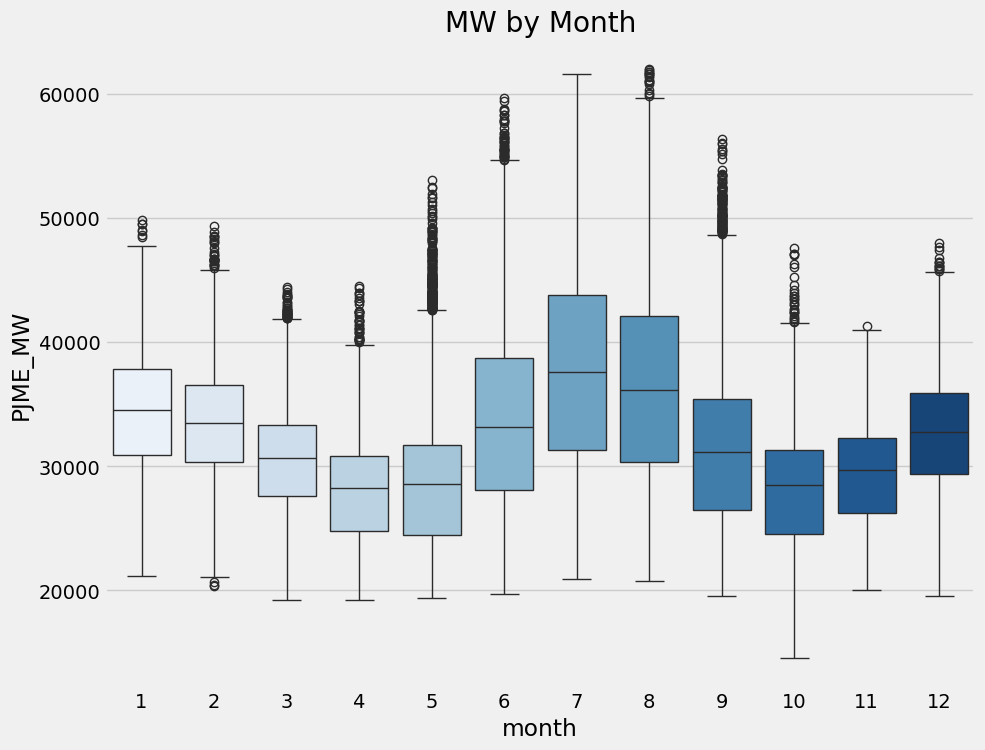

In [26]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## **Preparing Data For Modelling**

In [28]:
train = create_features(train)
test = create_features(test)

FEATURES_LR = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    ]
TARGET = 'PJME_MW'


FEATURES_XGB = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'lag_1d', 'lag_1w', 'lag_1m', 'lag_1y',
    'rolling_mean_3d', 'rolling_mean_30d', 'rolling_mean_same_month_last_year', 'rolling_mean_same_week_last_year'
]

In [29]:
# Linear Regression Data
X_train_lr = train[FEATURES_LR]
y_train_lr = train[TARGET]

X_test_lr = test[FEATURES_LR]
y_test_lr = test[TARGET]

# XGBoost Data
X_train_xgb = train[FEATURES_XGB]
y_train_xgb = train[TARGET]

X_test_xgb = test[FEATURES_XGB]
y_test_xgb = test[TARGET]

## **Linear Regression**

In [31]:
# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train_lr, y_train_lr)

# Make predictions
y_pred_lr = lr.predict(X_test_lr)

In [32]:
# @title **Evaluating Linear Regression**
rmse_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
mae_lr = mean_absolute_error(y_test_lr, y_pred_lr)

print(f"Linear Regression - RMSE: {rmse_lr}")
print(f"Linear Regression - MAE: {mae_lr}")

Linear Regression - RMSE: 5671.9471857735225
Linear Regression - MAE: 4588.8000592480075


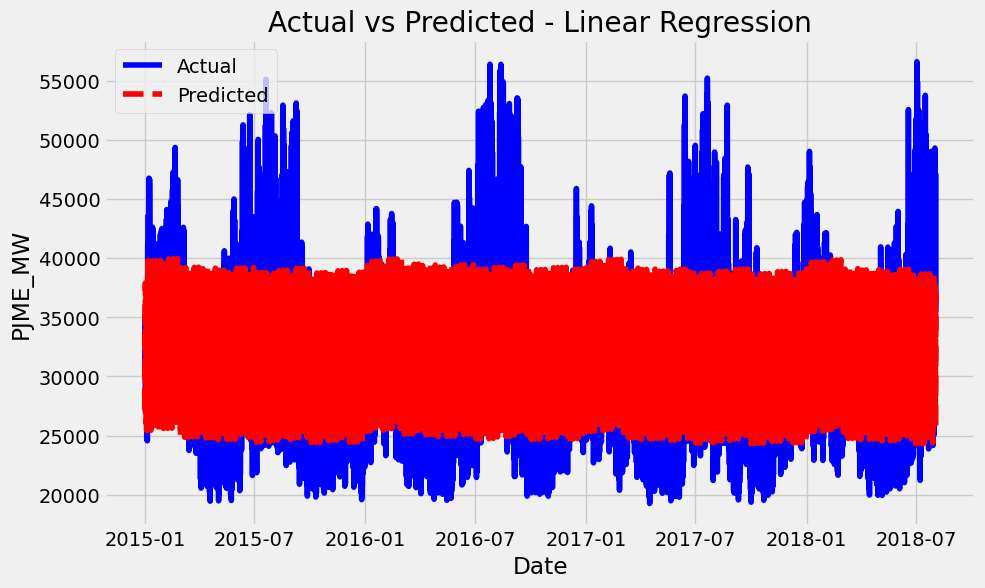

In [33]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_lr.index, y_test_lr, label='Actual', color='blue')
plt.plot(y_test_lr.index, y_pred_lr, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - Linear Regression')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

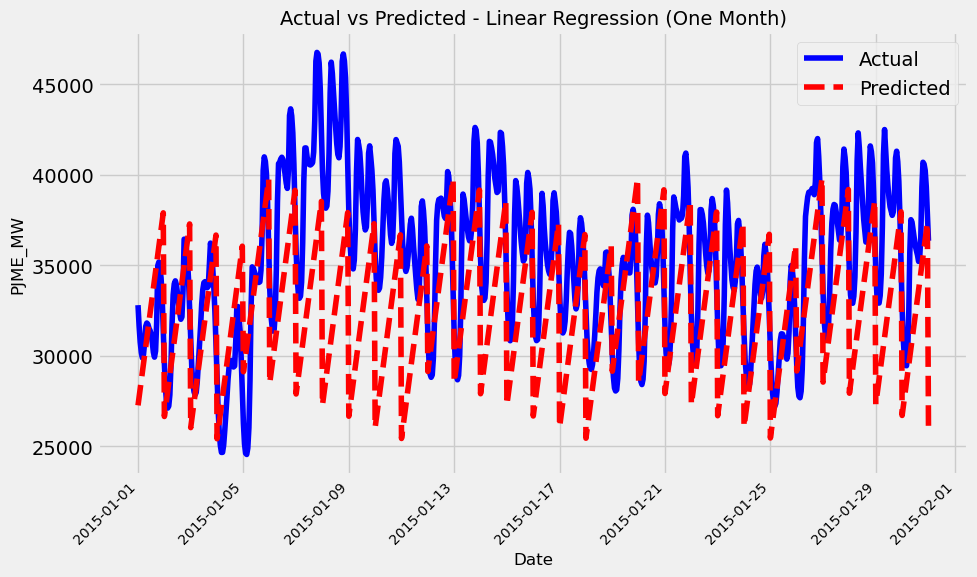

In [34]:
# Define the start and end date of the month interested in
# For example, let's take the first month from the test data range
start_date = y_test_lr.index[0].replace(day=1)  # Start of the month
end_date = (start_date + pd.DateOffset(months=1)) - pd.Timedelta(days=1)  # End of the month

# Filter for the month
y_test_month = y_test_lr.loc[start_date:end_date]

# Ensure y_pred_lr is a pandas series with the same index as y_test
y_pred_lr_series = pd.Series(y_pred_lr, index=y_test_lr.index)

# Now filter the predictions for the same month
y_pred_lr_month = y_pred_lr_series.loc[start_date:end_date]

# Plot actual vs predicted for one month
plt.figure(figsize=(10, 6))
plt.plot(y_test_month.index, y_test_month, label='Actual', color='blue')
plt.plot(y_test_month.index, y_pred_lr_month, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - Linear Regression (One Month)', fontsize=14)  # Adjust title font size
plt.xlabel('Date', fontsize=12)  # Adjust x-axis label font size
plt.ylabel('PJME_MW', fontsize=12)  # Adjust y-axis label font size
plt.legend()

# Reduce size of x-axis labels and rotate for readability
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust x-axis label font size here

plt.tight_layout()  # Ensure labels don't get cut off
plt.show()

# **XGBoost**

In [36]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 3,  # Depth of the trees
    'learning_rate': 0.01,  # Learning rate
    'colsample_bytree': 0.8,  # Subsample of features
    'subsample': 0.8  # Subsample ratio
}

# Watchlist for monitoring performance on train and test sets
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Number of boosting rounds and early stopping
num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Early stopping

# Train the model
reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)

# # Predict on the test set
y_pred_xgb = reg.predict(dtest)

# # Evaluate the performance (optional, to see RMSE)
# from sklearn.metrics import mean_squared_error
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"Test RMSE: {rmse}")

[0]	train-rmse:6392.80262	eval-rmse:6461.19660


C:\Users\Bobby\anaconda3\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[100]	train-rmse:2748.66676	eval-rmse:2766.52440
[200]	train-rmse:1497.11854	eval-rmse:1499.97524
[300]	train-rmse:1056.51917	eval-rmse:1046.76129
[400]	train-rmse:868.76142	eval-rmse:864.84827
[500]	train-rmse:781.98938	eval-rmse:783.64155
[600]	train-rmse:729.72623	eval-rmse:735.69505
[700]	train-rmse:686.92053	eval-rmse:695.09333
[800]	train-rmse:654.83595	eval-rmse:666.13775
[900]	train-rmse:630.74356	eval-rmse:644.61960
[999]	train-rmse:605.96294	eval-rmse:623.54135


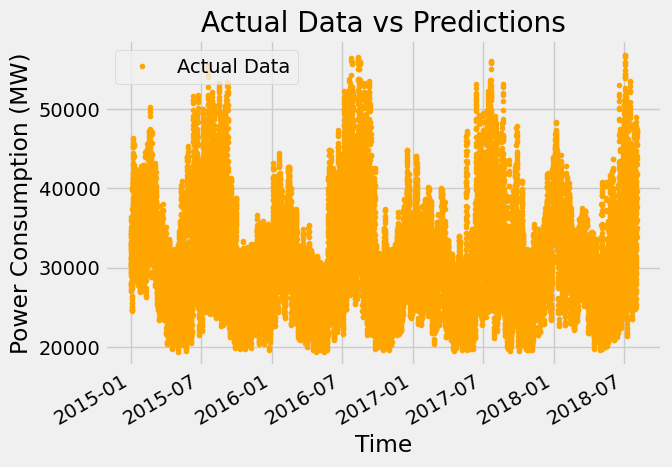

In [74]:
# Ensure that 'prediction' column is added only once
if 'prediction' not in df.columns:
    test['prediction'] = reg.predict(dtest)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot the actual and predicted values
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.', color='orange')

# Add labels and legend
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Actual Data vs Predictions')
plt.xlabel('Time')
plt.ylabel('Power Consumption (MW)')

# Show the plot
plt.show()

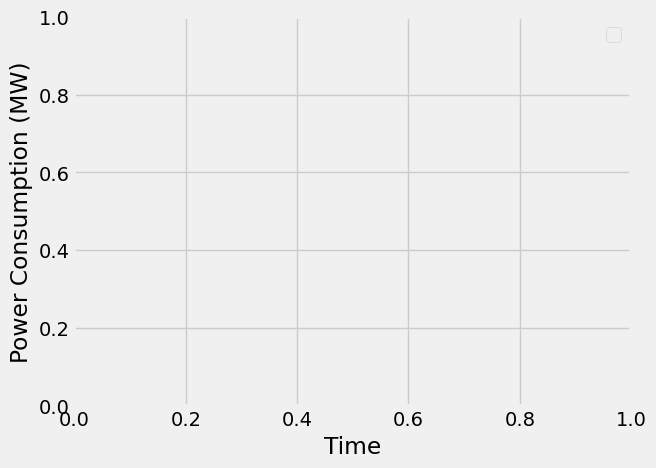

In [38]:
df['prediction'].plot(ax=ax, style='.', color='orange')

# Add labels and legend
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Actual Data vs Predictions')
plt.xlabel('Time')
plt.ylabel('Power Consumption (MW)')

# Show the plot
plt.show()

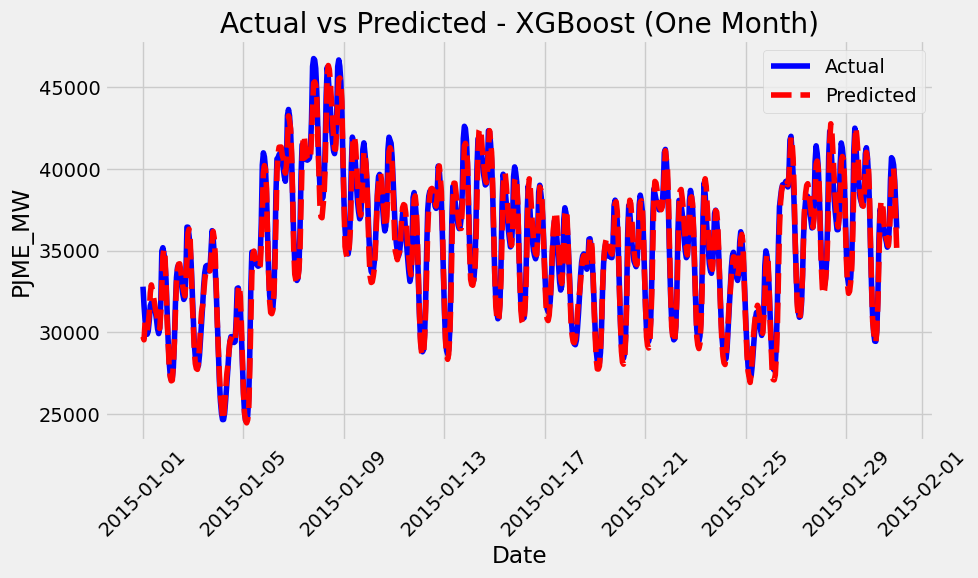

In [39]:
# Ensure that 'prediction' column is added only once
if 'prediction' not in df.columns:
    test['prediction'] = reg.predict(dtest)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


# Define the start and end date of the month interested in
start_date = y_test_xgb.index[0].replace(day=1)  # Start of the month
end_date = (start_date + pd.DateOffset(months=1)) - pd.Timedelta(days=1)  # End of the month

# Filter for the month for both actual and predicted values
y_test_month = y_test_xgb.loc[start_date:end_date]

# Ensure that 'prediction' column is aligned with the same index as y_test_month
y_pred_xgb_month = df['prediction'].loc[start_date:end_date]

# Plot actual vs predicted for one month
plt.figure(figsize=(10, 6))
plt.plot(y_test_month.index, y_test_month, label='Actual', color='blue')
plt.plot(y_test_month.index, y_pred_xgb_month, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - XGBoost (One Month)')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [40]:
# @title **Evaluating XGBoost**
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb}")
print(f"XGBoost - MAE: {mae_xgb}")

XGBoost - RMSE: 623.5413449792042
XGBoost - MAE: 482.45105421537056
